# Predicting Daily Bike Rentals

A bike share system is a service in which bicycles are made available for shared use to individuals on a short term basis for a price or free [source](https://en.wikipedia.org/wiki/Bicycle-sharing_system). The dataset related to the bike rental has been realized by Hadi Fanaee-T at the University of Porto, that can be found [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).
The goal of this project is to predict the total number of bikes people rented in a given hour.

To this end different machine learning techniques will be developed, in particular Decison Tree, Random Forest and AdaBoost along with the evaluation of their performances in order to select the one that better describes the considered dataset and that can make the most accurate prediction.


The project will be structured as follows:

1) Analysis and Data Preparation

2) Definition of useful functions (e.g. for cross-validation, test/train split, computation of metrics of interest etc.)

3) Models Evaluation

4) Analysis of features importance

5) Robustness Analysis
    
6) Hyperparameter Optimization

## Analysis and Data Preparation

**You will need to import some useful packages for the exercises. You can write them here.**

In [1]:
# Imports
import os
import pandas as pd
import json
import matplotlib
import numpy as np
import seaborn as sns   
import matplotlib.pyplot as plt
import warnings

# ML
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score

# Set some useful options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

**Now import the dataset and take a look at it to have a better understanding of the features and to identify the response variable. Write down some comments about them.**

In [2]:
# import the dataset
bike_rentals = pd.read_csv("../data/hour.csv")
# diplay the first few row in order to take a look at the data
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
bike_rentals.shape

(17379, 17)

As we can see the dataset contains 17 columns and 17379 rows. The description of the most important features is the following:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)


Since we want to predict the total number of bike rentals, the *cnt* column represents the labels column.

We can now consider the type of each column in order to evaluate whether we need to convert some of them for the analysis

In [4]:
bike_rentals.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

**Consider the type of each feature and identify the one/s that may not work for a machine learning framework. Would it be useful to convert it/them or should we drop it/them?
Moreover think about the yr column: could we also drop this feature?**


**Take now a loolk at the *instant* column: do you think it would be helpful in predicting the bike rental? Why?**

Only the *dteday* column is of 'object' type, which is not a good data type to be used for a machine learning framework. Moreover to achieve the final goal of predicting the total number of bike rentals, the information about the year and the day may not be very useful. On the other hand the information related to the month may be important, however it is already stored in the *mnth* column, so we can drop *dteday*. For the same reason one may want to drop *yr* column.

In [5]:
# Drop 'dteday' column
bike_rentals.drop(columns = ['dteday', 'yr'], axis = 1, inplace = True)

In [6]:
bike_rentals.head()

,instant,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Let us evaluate the distribution of the total rentals

**Evaluate now the distribution of the total rentals and comment the results.**

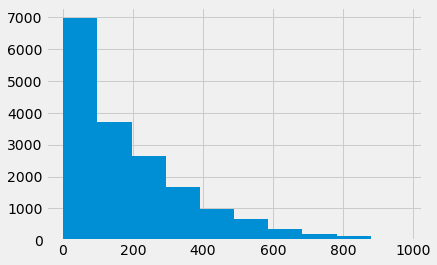

In [7]:
# Build an histogram of the "cnt" column
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# hist function is used with the number of bins set to 10
# which means that we devide our interval of values in 10 parts
plt.hist(bike_rentals['cnt'], bins = 10)
plt.show()

As we can see the total number of bike rentals most frequent values are the ones between 0 and 100. Indeed we can find these values in almost 7000 samples. The frequency of values assumed by the total number of bike rentals variable decreases almost esponentially when increasing these values. This is intuitive since it is likely that in few, special occasion the number to rented bikes can increase drammatically (arriving at 900), while most of the time its value is between 0 and 200.  

**Another way to select the most useful features for your machine learning problem is to evaluate the correlation analysis: features that are highly correlated between them bring redundant information into the analysis, so could be useful to drop one of them. Moreover it is also useful to check which features are more correlated with the response variable.**

**Perform a correlation analysis and evaluate the features which are more correlated with the response variable and ask yourself if it would be fair for your analysis to keep them. Why?**

**Take now a look at the features that are highly correlated between them: which one could we drop?**

We can investigate how each column is correlated with *cnt*. This is in genral a good indicator for the feature selection process.

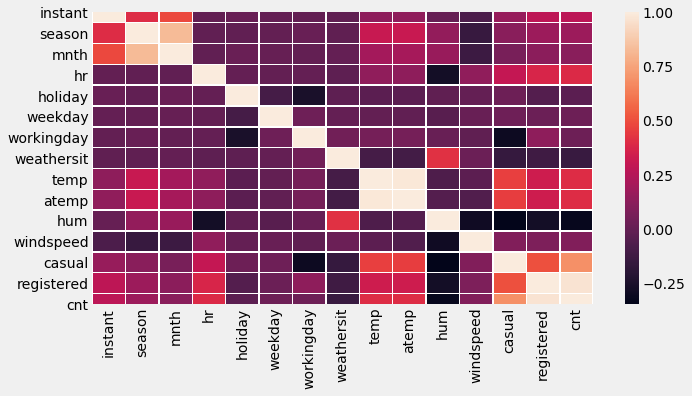

In [8]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,5))         # Sample figsize in inches
sns.heatmap(bike_rentals.corr(), linewidths=.5, ax=ax)
#sns.heatmap(bike_rentals.corr())
plt.show()

In [9]:
bike_rentals[bike_rentals.columns[1:]].corr()['cnt'][:].sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

It looks like the *casual* and *registered* column have the highest correlation values with the response variable, that is the total number of bike rentals (*cnt*). This is expected since *cnt* is derived from them. Indeed if you're trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that you'd already know casual or registered, because those numbers are added together to get cnt.
This is why we will remove them from the dataset.

In [10]:
bike_rentals.drop(['casual', 'registered'], axis = 1, inplace = True)

Moreover, as one can expect, there is a high correlation between *season* and *month* column. So one can drop one of the two. We decided to drop the *month* column just because maybe we do not need such a granularity of the information. Other two columns which are highly correlated are *temp* and *atemp* because of the fact that one is the adjusted value of the other. Let us drop the *atemp* column since the *temp* one is more intuitive to interprete.

In [11]:
bike_rentals.drop(['mnth', 'atemp'], axis = 1, inplace = True)

### Manipulate Columns to Extract Useful Features

**Now manipulate the hr column that contains rental hours, from 1 to 24. In particular you can put together a specific time interval to identify a specific moment of the day (e.g. morning from 6am to 12pm) that can be associated with an identifier. One idea is the following:**

**- 1 if the hour is from 6 to 12**

**- 2 if the hour is from 12 to 18**

**- 3 if the hour is from 18 to 24**

**- 4 if the hour is from 0 to 6**

In [12]:
def assign_label(val):
    if((val>=6) and (val<=12)):
        final_val = 1#morning etc
    if((val>=12) and (val<=18)):
        final_val = 2
    if((val>=18) and (val<=24)):
        final_val = 3
    if((val>=0) and (val<=6)):
        final_val = 4
    return final_val

In [13]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [14]:
bike_rentals.drop(columns= 'hr', axis = 1, inplace=True)

In [15]:
# let us look at the dataset again
bike_rentals.head()

,instant,season,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time_label
0,1,1,0,6,0,1,0.24,0.81,0.0,16,4
1,2,1,0,6,0,1,0.22,0.80,0.0,40,4
2,3,1,0,6,0,1,0.22,0.80,0.0,32,4
3,4,1,0,6,0,1,0.24,0.75,0.0,13,4
4,5,1,0,6,0,1,0.24,0.75,0.0,1,4


Finally we decided to drop the *instant* column since it represents a unique sequential ID number for each row that may not be that helpful in predicting the bike rental. 

In [16]:
bike_rentals.drop(columns= 'instant', axis = 1, inplace=True)

In [17]:
bike_rentals.head()

,season,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time_label
0,1,0,6,0,1,0.24,0.81,0.0,16,4
1,1,0,6,0,1,0.22,0.80,0.0,40,4
2,1,0,6,0,1,0.22,0.80,0.0,32,4
3,1,0,6,0,1,0.24,0.75,0.0,13,4
4,1,0,6,0,1,0.24,0.75,0.0,1,4


In [18]:
bike_rentals.shape

(17379, 10)

In [19]:
bike_rentals.describe()

,season,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time_label
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.028770,3.003683,0.682721,1.425283,0.496987,0.627229,0.190098,189.463088,2.617700
std,1.106918,0.167165,2.005771,0.465431,0.639357,0.192556,0.192930,0.122340,181.387599,1.109081
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.480000,0.104500,40.000000,2.000000
50%,3.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.630000,0.194000,142.000000,3.000000
75%,3.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.780000,0.253700,281.000000,4.000000
max,4.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,0.850700,977.000000,4.000000


**Use the function .describe() to inspect the values of each column: arew they consistent in terms of values  or should we normalize them?**

##  Definition of useful functions

**In this section you are asked to write some usefull functions:**

**Cross_Val(splits, features, target, model)**: 

This function compute the cross validation in order to estimate the error of the modle with respect to unseen data. The estimation is done by avaraging the performance of the model over different subsets of the training set, divided into training and validation set. The function takes as input the number of splits, the features matrix and the target of the training set and the model. The function should return the R-squared and the train and the test root mean squared error normalized with respect to the variation of the target values (max value - min value). 

Hint: use KFold to split the training features matrix into train and validation.

**Test(X_train, y_train, X_test, y_test, model)**:

This function is used to train the model with all the training set and then to test the trained model with the test set. Use as metric the normalized root mean squared error (RMSE/(max(target value)-min(target value))) and the R-squared. The function takes as input the training test (features and target) and the test set (features and target).

**Test_Train_Random(data)**:

This fucntion should randomly give as output the indices of the original dataset that should belong to the training (80%) and test set (20%).

Hint: use random.Random(1).shuffle()

In [20]:
# Define useful function for k-fold cross validation
def Cross_Val(splits, features, target, model):
    
    rmse_values_train = []
    rmse_values_test = []
    # KFold instance.
    kf = KFold(n_splits=splits, shuffle=True, random_state=3)
    
    # Iterate through over each fold.
    for train_index, test_index in kf.split(features):
        # Training and test sets.
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Fit the model and make predictions.
        model.fit(X_train, y_train)
        predictions_test = model.predict(X_test)
        predictions_train = model.predict(X_train)
        
        # Calculate mse and variance values for this fold.
        rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
        rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
        max_test_label = np.max(y_test)
        min_test_label = np.min(y_test)
        max_train_label = np.max(y_train)
        min_train_label = np.min(y_train)
        delta_test = max_test_label-min_test_label
        delta_train = max_train_label-min_train_label
        
        # Append to arrays to do calculate overall average mse and variance values.
        rmse_values_test.append((rmse_test/delta_test)*100)
        rmse_values_train.append((rmse_train/delta_train)*100)
    avg_rmse_test = np.mean(rmse_values_test)
    avg_rmse_train = np.mean(rmse_values_train)
    return(round(avg_rmse_test, 3), round(avg_rmse_train, 3))


In [21]:
def test(X_train, y_train, X_test, y_test, model, plot_res=False):
    # Fit the model and make predictions.
    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)

    # Calculate mse and variance values for this fold.
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
    max_test_label = np.max(y_test)
    min_test_label = np.min(y_test)
    delta_test = max_test_label-min_test_label
    if(plot_res):
        Plot_Results(y_test, predictions_test)
    # Append to arrays to do calculate overall average mse and variance values.
    print('R2: '+ str(round(r2_score(y_test, predictions_test), 3)))
    print('Normalized RMSE as % is = '+ str(round((rmse_test/delta_test)*100)))
    return round((rmse_test/delta_test)*100)

In [22]:
# cross validation on the training set
def Evaluate (model, X_train, y_train,  X_test, y_test, plot_res=False):
    splits = 10
    avg_rmse_test, avg_rmse_train = Cross_Val(splits, X_train, y_train, model)
    print(avg_rmse_test, avg_rmse_train)
    # Test Model
    res = test(X_train, y_train, X_test, y_test, model, plot_res)
    #print(res)
    return res

In [23]:
def Plot_Results(y_test, predictions_test):
    plt.figure()
    plt.scatter(y_test, predictions_test)
    axes = plt.gca()
    axes.set_xlim([0,1000])
    axes.set_ylim([0,1000])
    plt.show()

In [24]:
import random

def Test_Train_Random(data):
    x = list(range(len(data)))
    random.Random(1).shuffle(x)
    limit = int(len(x)*.8)
    index_train = x[:limit]
    index_test = x[limit:]
    return index_train, index_test

## Models Evaluation

To predict the bike rental we will use the following classifiers:
- Decision Tree
- Random Forest 
- Adaboost

We will show the overfitting problem in the case of the Decision Tree by comparing the training error with the test error and then we will evaluate how to reduce such an overfitting by using the Random Forest algortihm. 
To this end we will use k-fold cross validation for training in a first part of the exercise. In the second part we will use k-fold cross validation for hyperparameter optimization. 

**First of all split the original datas into train_set and test_set by using the indices provided by the Test_Train_Random function. After that divide the test and the training sets into X_train (for the features) / y_train (for the label) and the X_test (for the features) / y_test (for the label) respectively.**

Hint: reset indices with reset_indx(drop=True) function.

In [25]:


# Data preparation

# Split data
index_train, index_test= Test_Train_Random(bike_rentals)
train_sets= bike_rentals.iloc[index_train]
train_sets= train_sets.reset_index(drop=True)
test_sets= bike_rentals.iloc[index_test]
test_sets= test_sets.reset_index(drop=True)

# features and target for training
feature_cols = test_sets.columns.values[test_sets.columns.values != 'cnt']

X_train = train_sets[feature_cols]
y_train = train_sets['cnt']

X_test = test_sets[feature_cols]
y_test = test_sets['cnt']

### Decision Tree

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability, which means that small changes in the input data can result in a very different output model.

In [26]:
# cross validation on the training set
model = DecisionTreeRegressor(random_state=1)
splits = 10
avg_rmse_test, avg_rmse_train = Cross_Val(splits, X_train, y_train, model)
avg_rmse_test, avg_rmse_train

(17.252, 2.121)

In [27]:
# Test Model
model = DecisionTreeRegressor(random_state=1)
test(X_train, y_train, X_test, y_test, model)
feature_importance_dt = model.feature_importances_

R2: 0.236
Normalized RMSE as % is = 16.0


As we can see from the results, by using a decision tree (without changing the default hyperparameters; see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)) the root mean squared error for the test set is much higher than the one for the train set. This is a clear sign of overfitting: our model is performing very well on the data used to build it, while it is poorely performing on unseen data. 
We can try to reduce this problem in two different ways:
- hyperparameter optimization (in this way using the some pruning technique)
- ensamble techniques (e.g. Random Forest)

### Random Forest

In [28]:
model = RandomForestRegressor(random_state=1)
splits = 10
avg_rmse_test, avg_rmse_train = Cross_Val(splits, X_train, y_train, model)
avg_rmse_test, avg_rmse_train

(13.226, 5.546)

In [29]:
# Test Model
model = RandomForestRegressor(random_state=1)
test(X_train, y_train, X_test, y_test, model)
feature_importance_rf = model.feature_importances_
model_estimators_rf = model.estimators_

R2: 0.546
Normalized RMSE as % is = 12.0


As expected Random Forest, with respect to Decision tree, performs in general better on the test set, and reduces the difference betwen the performance between root mean squared error related to the test and train sets. Also in this case all the parameters used for the Random Forest are the default ones (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html))

### AdaBoost

In [30]:
model = AdaBoostRegressor(random_state=1)
splits = 10
avg_rmse_test, avg_rmse_train = Cross_Val(splits, X_train, y_train, model)
avg_rmse_test, avg_rmse_train

(14.84, 13.999)

In [31]:
# Test Model
model = AdaBoostRegressor(random_state=1)
test(X_train, y_train, X_test, y_test, model)
feature_importance_ab = model.feature_importances_
model_estimators_ab = model.estimators_

R2: 0.404
Normalized RMSE as % is = 14.0


**Initialize here 3 different models: DecisionTreeRegressor, RandomForestRegressor and AdaBoostRegressor. Remember to set the random_state parameter to a value in order to have repeatable results (see Scikit-Learn documentation). Using the Cross_Val function, with 10 splits, evaluate the prediction error estimation for the training set and the validation set. Then test your model using the Test function. In this operation store the feature importances and the estimators information for each model with the following commands:**

feature_importance = model.feature_importances_

model_estimators = model.estimators_

**Answer the following questions:**

### *Questions*
- By using the Cross_Val function you have estimated the prediction error of the model in predicting the training labels and the validation labels. Which one is always bigger? Why?
- How these two errors change according to the model used? Why? 

## Analysis of features importance
Given the generated model, evaluate the contribution of each feature and see how the importance of such features change over the algorithms.

**In this part you are asked to evaluate the importance of each feature. In the previous section you have stored the feature_importances_ for each model. Plot them using a bar plot and answer the following questions:**


### *Questions*
- Is the features contribution in each algorithm consistent?
- Are the most important features coherent with a common interpretation? Why?

In [32]:
def Feature_Importance(feature_importance, algorithm, xlabel):
    x = np.arange(len(np.sort(feature_importance)))
    plt.xticks(rotation=90)
    plt.bar(xlabel,np.sort(feature_importance))
    plt.title(algorithm)
    plt.show()

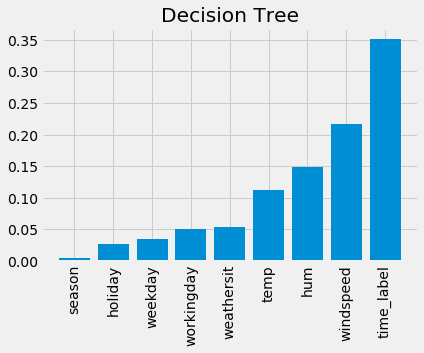

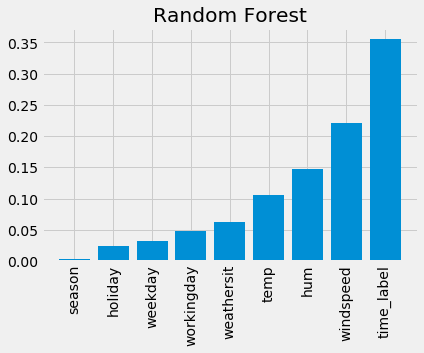

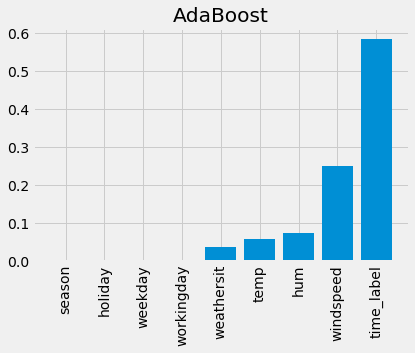

In [33]:
feature_importance = [feature_importance_dt, feature_importance_rf, feature_importance_ab]
algorithm_vect = ['Decision Tree', 'Random Forest', 'AdaBoost']
xlabel = X_train.columns.values
for fi,algorithm  in zip(feature_importance, algorithm_vect):
    Feature_Importance(fi, algorithm, xlabel)

In all the cases it looks like the top 4 features are:
- the time of the day 
- the windspeed
- the humidity level
- the temperature.

This result is not surprising since it is common to use the bike in specific time of the day and according to the weather condition. It is interesting to notice that with AdaBoost one can think of completely excluding certain features from the computation since they do not give any contribution to the prediction.

## Robustness Analysis

**In this section you are asked to add noise to the features of the training set and then train the model with this noisy dataset. Then test the model with the test set and check whether how much the test error of each moidel is affected by the noise addition. Set the noise as follows:**

noise = np.random.rand(X_train.shape[0])*val

X_train_noisy = X_train.copy()

for col in X_train.columns:

        X_train_noisy[col] = X_train_noisy[col]+noise

**where val should vary in the following range: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10].**

**NB since it is a random noise, in order to have repeatable results use np.random.seed(seed_number) where you can set a specific seed_number.**

**Plot the results for each model at each val value, and answer the following questions:***

### *Questions*
- How do the performance of each model change while increasing the noise? 
- Which algorithm is more affected by the addition of the noise? And which one is more robust?
- Did you expect these results? Why?

### Noise addition

There are several ways to add noise in the your dataset. In our case we are considering to add random noise in the training 

In [34]:
def Add_Noise(val):
    np.random.seed(52)#(2)6,8
    noise = np.random.rand(X_train.shape[0])*val
    X_train_noisy = X_train.copy()
    for col in X_train.columns:
        X_train_noisy[col] = X_train_noisy[col]+noise
        
    #Decision Tree
    model = DecisionTreeRegressor(random_state=1)
    dt = Evaluate(model, X_train_noisy, y_train, X_test, y_test)
    
    #Random Forest
    model = RandomForestRegressor(random_state=1)
    rf = Evaluate(model, X_train_noisy, y_train, X_test, y_test)
    
    #AdaBoost
    model = AdaBoostRegressor(random_state=1)
    ab = Evaluate(model, X_train_noisy, y_train, X_test, y_test)
    return dt, rf, ab

In [35]:
dt = []
rf = []
ab = []
range_ = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for val in range_:
    dt_tmp, rf_tmp, ab_tmp = Add_Noise(val)
    dt.append(dt_tmp)
    rf.append(rf_tmp)
    ab.append(ab_tmp)

17.252 2.121
R2: 0.236
Normalized RMSE as % is = 16.0
13.226 5.546
R2: 0.546
Normalized RMSE as % is = 12.0
14.84 13.999
R2: 0.404
Normalized RMSE as % is = 14.0
18.402 0.0
R2: -0.19
Normalized RMSE as % is = 20.0
13.929 5.595
R2: 0.437
Normalized RMSE as % is = 14.0
15.566 14.696
R2: 0.361
Normalized RMSE as % is = 15.0
18.826 0.0
R2: -0.318
Normalized RMSE as % is = 21.0
14.223 5.74
R2: 0.383
Normalized RMSE as % is = 14.0
16.583 15.623
R2: -0.06
Normalized RMSE as % is = 19.0
19.024 0.0
R2: -0.063
Normalized RMSE as % is = 19.0
14.489 5.793
R2: 0.336
Normalized RMSE as % is = 15.0
17.514 16.517
R2: -0.048
Normalized RMSE as % is = 19.0
19.275 0.0
R2: -0.494
Normalized RMSE as % is = 22.0
14.492 5.822
R2: 0.304
Normalized RMSE as % is = 15.0
17.803 16.831
R2: -0.025
Normalized RMSE as % is = 19.0
19.541 0.0
R2: -0.296
Normalized RMSE as % is = 21.0
14.689 5.911
R2: 0.375
Normalized RMSE as % is = 15.0
18.382 17.267
R2: -0.134
Normalized RMSE as % is = 20.0
19.504 0.0
R2: -0.357
Norma

In [36]:
Table = pd.DataFrame({'Decision Tree':dt, 'Random Forest':rf, 'AdaBoost':ab})
Table

,Decision Tree,Random Forest,AdaBoost
0,16.0,12.0,14.0
1,20.0,14.0,15.0
2,21.0,14.0,19.0
3,19.0,15.0,19.0
4,22.0,15.0,19.0
5,21.0,15.0,20.0
6,21.0,15.0,19.0
7,20.0,15.0,21.0
8,20.0,16.0,21.0
9,19.0,14.0,20.0


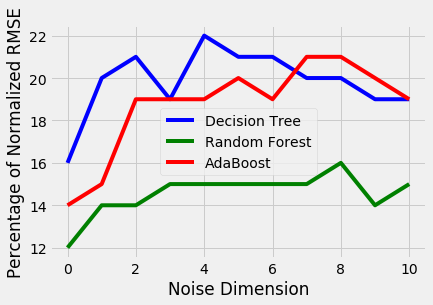

In [38]:
plt.figure()
plt.plot(range_, dt, 'b')
plt.plot(range_, rf, 'g')
plt.plot(range_, ab, 'r')
plt.legend(['Decision Tree', 'Random Forest', 'AdaBoost'])
plt.xlabel('Noise Dimension')
plt.ylabel('Percentage of Normalized RMSE')
plt.show()

## Hyperparameter Optimization

**In this section you are asked to optimize some hyperparameters of the models under analysis (Decision Tree, Random Forest and AdaBoost). For each hyperparameter you should define a set of values to test and then combine all the sets into a dictionary structure. Use the RandomizedSearchCV function to search the hyper-parameter space for the best cross validation score (see [documentation](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)). Compare the results given by the best hyperparameters combination with respect to the default model.**

### *Questions*
- Can we improve the performance of the models by optimizing the hyperameters?
- What is the bottleneck in the hyperparameters optimization? How would you handle this problem? (two many combinations --> decrease granularity --> find range and then increase details)

In [39]:
def Hyperp_Optim(hyperp, model):
    clf = RandomizedSearchCV(model, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)
    print('Normalized RMSE with hyperparameter optimization:')
    with_ = test(X_train, y_train, X_test, y_test, clf)
    print(with_)
    print('Normalized RMSE without hyperparameter optimization:')
    without_ = test(X_train, y_train, X_test, y_test, model)
    print(without_)
    

In [40]:
# Decision Tree
max_depth_range = [20, 30, 40]#range(1, 10)
min_samples_leaf_range = [2, 5, 10]#range(1, 10)
# Create hyperparameter options
hyperparameters = dict(max_depth=max_depth_range, min_samples_leaf=min_samples_leaf_range)

model = DecisionTreeRegressor(random_state=1)
Hyperp_Optim(hyperparameters, model)

Normalized RMSE with hyperparameter optimization:
R2: 0.528
Normalized RMSE as % is = 13.0
13.0
Normalized RMSE without hyperparameter optimization:
R2: 0.236
Normalized RMSE as % is = 16.0
16.0


In [41]:
# Random Forest
max_depth_range = [20, 30, 40]#range(1, 10)
min_samples_leaf_range = [2, 5, 10]#range(1, 10)
n_estimators_range= [50, 100, 200]
# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators_range, max_depth=max_depth_range, min_samples_leaf=min_samples_leaf_range)

model = RandomForestRegressor(random_state=1)
Hyperp_Optim(hyperparameters, model)

Normalized RMSE with hyperparameter optimization:
R2: 0.59
Normalized RMSE as % is = 12.0
12.0
Normalized RMSE without hyperparameter optimization:
R2: 0.546
Normalized RMSE as % is = 12.0
12.0


In [42]:
# Adaboost
n_estimators_range= [1000, 2000, 9000]
learning_rate = [.1, .5, 1.5]
# Create hyperparameter options
hyperparameters = dict(learning_rate = learning_rate, n_estimators=n_estimators_range)

model = AdaBoostRegressor(random_state=1)
Hyperp_Optim(hyperparameters, model)

Normalized RMSE with hyperparameter optimization:
R2: 0.419
Normalized RMSE as % is = 14.0
14.0
Normalized RMSE without hyperparameter optimization:
R2: 0.404
Normalized RMSE as % is = 14.0
14.0
